In [1]:
import pandas

size_log = pandas.read_pickle("5-generated-mdps/success.pkl.gz")
aborts = pandas.read_pickle("5-generated-mdps/fail.pkl.gz")

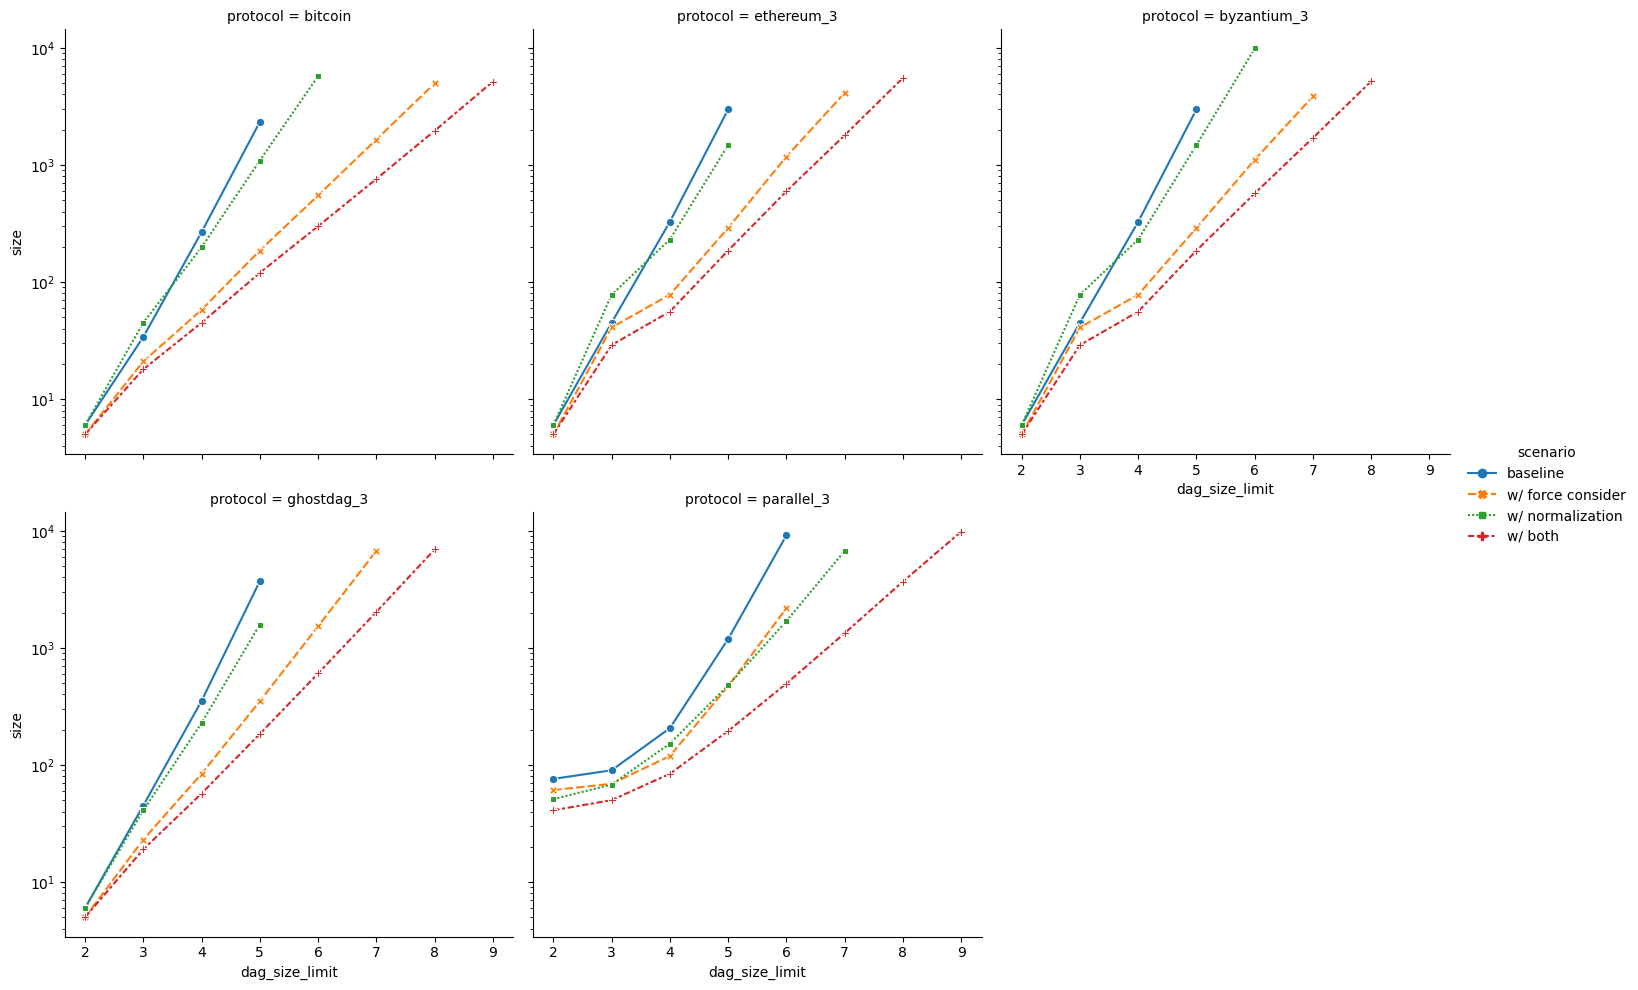

In [2]:
import seaborn

seaborn.relplot(
    data=size_log.query("dag_size_limit < 10"),
    kind="line",
    x="dag_size_limit",
    y="size",
    hue="scenario",
    style="scenario",
    markers=True,
    col="protocol",
    col_wrap=3,
).set(yscale="log")

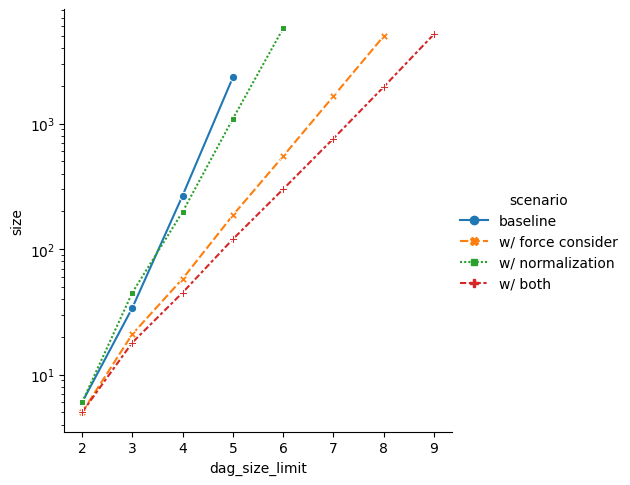

In [3]:
seaborn.relplot(
    data=size_log.query("protocol == 'bitcoin' and dag_size_limit < 13"),
    kind="line",
    x="dag_size_limit",
    y="size",
    hue="scenario",
    style="scenario",
    markers=True,
).set(yscale="log")

In [4]:
scenario_labels = {
    "reference": "reference-fc16",
    "reference-v0": "drop",
    "baseline": "baseline",
    "w/o garbage collection": "baseline-gc",
    "w/ force consider": "baseline+fc",
    "w/ normalization": "baseline+n",
    "w/ both": "baseline+fc+n",
}

cutoff = max(size_log.query("scenario != 'reference'").dag_size_limit) + 1

btc_size = (
    size_log.assign(scenario=[scenario_labels[x] for x in size_log.scenario])
    .query("scenario != 'drop'")
    .query("protocol == 'bitcoin'")
    .query(f"dag_size_limit <= {cutoff}")
    .pivot(index="dag_size_limit", columns="scenario", values="size")
)

btc_size.to_csv("5-state-space-exploration-viz-for-paper-btc-size.csv")
btc_size

scenario,baseline,baseline+fc,baseline+fc+n,baseline+n
dag_size_limit,,,,
2,6.0,5.0,5.0,6.0
3,34.0,21.0,18.0,45.0
4,267.0,58.0,45.0,198.0
5,2332.0,186.0,120.0,1092.0
6,NaN,549.0,300.0,5730.0
7,NaN,1650.0,760.0,NaN
8,NaN,4968.0,1959.0,NaN
9,NaN,NaN,5153.0,NaN


In [5]:
# how should we report on the other protocols?
# column a: show max depth explored in table for fully optimized exploration only; calculate blow up factor and add as columns


def tabulate_deepest(d):
    return d.iloc[d.groupby(["scenario", "protocol"]).dag_size_limit.idxmax()]


biggest = (
    tabulate_deepest(size_log)
    .reset_index(drop=True)
    .query("scenario != 'w/o garbage collection'")
    .query("scenario != 'reference-v0'")
)

biggest.to_pickle("5-generated-mdps/biggest.pkl.gz")

biggest

,scenario,model,protocol,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,dag_size_limit,size,time_spent,rss,mdp
0,baseline,generic_1,bitcoin,False,False,True,True,False,5,2332,1.170060,0.194645,2c9e4172
1,baseline,generic_1,byzantium_3,False,False,True,True,False,5,2981,1.750282,0.208431,12e30c3f
2,baseline,generic_1,ethereum_3,False,False,True,True,False,5,2981,1.585207,0.203613,2d304f18
3,baseline,generic_1,ghostdag_3,False,False,True,True,False,5,3712,2.612529,0.210197,47b0e15e
4,baseline,generic_1,parallel_3,False,False,True,True,False,6,9122,5.442421,0.253792,6037e1f1
5,w/ both,generic_1,bitcoin,True,True,True,True,False,9,5153,7.473501,0.237740,546cfa43
6,w/ both,generic_1,byzantium_3,True,True,True,True,False,8,5187,7.328147,0.235546,3363db19
7,w/ both,generic_1,ethereum_3,True,True,True,True,False,8,5535,6.921371,0.237991,7f418cdb
8,w/ both,generic_1,ghostdag_3,True,True,True,True,False,8,6914,14.657826,0.248909,1df6d8f4
9,w/ both,generic_1,parallel_3,True,True,True,True,False,9,9817,13.515648,0.284737,4895cb12


In [6]:
# how should we report on the other protocols?
# column b: fix depth in table

fixed_cutoff = min(biggest.dag_size_limit)
fixed = (
    size_log.query("scenario != 'w/o garbage collection'")
    .query("scenario != 'reference-v0'")
    .query(f"dag_size_limit == {fixed_cutoff}")
    .reset_index(drop=True)
)
fixed.to_pickle("5-generated-mdps/fixed.pkl.gz")
fixed

,scenario,model,protocol,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,dag_size_limit,size,time_spent,rss,mdp
0,baseline,generic_1,bitcoin,False,False,True,True,False,5,2332,1.170060,0.194645,2c9e4172
1,baseline,generic_1,ethereum_3,False,False,True,True,False,5,2981,1.585207,0.203613,2d304f18
2,baseline,generic_1,byzantium_3,False,False,True,True,False,5,2981,1.750282,0.208431,12e30c3f
3,baseline,generic_1,ghostdag_3,False,False,True,True,False,5,3712,2.612529,0.210197,47b0e15e
4,baseline,generic_1,parallel_3,False,False,True,True,False,5,1189,0.591845,0.223396,6020b2cd
5,w/ force consider,generic_1,bitcoin,True,False,True,True,False,5,186,0.079336,0.215008,1926ab59
6,w/ force consider,generic_1,ethereum_3,True,False,True,True,False,5,290,0.151904,0.217701,144e6221
7,w/ force consider,generic_1,byzantium_3,True,False,True,True,False,5,290,0.176827,0.217888,575758f7
8,w/ force consider,generic_1,ghostdag_3,True,False,True,True,False,5,350,0.307172,0.217567,437e33c9
9,w/ force consider,generic_1,parallel_3,True,False,True,True,False,5,470,0.244254,0.233822,50222e16


In [7]:
combined = pandas.DataFrame(
    dict(
        max_dag_size_limit=biggest.set_index(["scenario", "protocol"]).dag_size_limit,
        size_at_fixed_dag_size=fixed.set_index(["scenario", "protocol"])["size"],
    )
).reset_index()
combined

,scenario,protocol,max_dag_size_limit,size_at_fixed_dag_size
0,baseline,bitcoin,5,2332
1,baseline,byzantium_3,5,2981
2,baseline,ethereum_3,5,2981
3,baseline,ghostdag_3,5,3712
4,baseline,parallel_3,6,1189
5,w/ both,bitcoin,9,120
6,w/ both,byzantium_3,8,186
7,w/ both,ethereum_3,8,186
8,w/ both,ghostdag_3,8,184
9,w/ both,parallel_3,9,195


In [8]:
fixed_cutoff

5

In [9]:
combined.query('scenario != "reference"').set_index(["scenario", "protocol"]).unstack(
    level=0
).stack(level=0, future_stack=True).unstack(level=1)

scenario              baseline                                   w/ both  \
            max_dag_size_limit size_at_fixed_dag_size max_dag_size_limit   
protocol                                                                   
bitcoin                      5                   2332                  9   
byzantium_3                  5                   2981                  8   
ethereum_3                   5                   2981                  8   
ghostdag_3                   5                   3712                  8   
parallel_3                   6                   1189                  9   

scenario                            w/ force consider                         \
            size_at_fixed_dag_size max_dag_size_limit size_at_fixed_dag_size   
protocol                                                                       
bitcoin                        120                  8                    186   
byzantium_3                    186                  7                    290   
ethereum_3                     186                  7                    290   
ghostdag_3                     184                  7                    350   
parallel_3                     195                  6                    470   

scenario      w/ normalization                         
            max_dag_size_limit size_at_fixed_dag_size  
protocol                                               
bitcoin                      6                   1092  
byzantium_3                  6                   1480  
ethereum_3                   5                   1480  
ghostdag_3                   5                   1581  
parallel_3                   7                    478